Iniciando Teste de Estresse de Risco de Liquidez (Simulação de Monte Carlo)
------------------------------------------------------------
Simulações (Cenário Base): 1,000,000
Período de teste: 30 dias
Ativos Líquidos Iniciais: R$ 15,000 milhões
Financiamento de Curto Prazo: R$ 50,000 milhões
Taxa de Saque (Estresse): 8.0% ao dia
Duração do Estresse: 10 dias
------------------------------------------------------------

--- Resultados do Teste de Estresse (Cenário Base) ---
Probabilidade de Falha de Liquidez em 30 dias: 26.0458%

RECOMENDAÇÃO (Base): ALTA PROBABILIDADE DE FALHA. Revisar o colchão de liquidez (HQLA).

--- Iniciando Análise de Sensibilidade ---
Analisando sensibilidade: LIQUID_ASSETS_INICIAL...
Analisando sensibilidade: TAXA_SAQUE_ESTRESSE...
Analisando sensibilidade: DIAS_ESTRESSE_DURACAO...
--- Geração de Gráficos ---


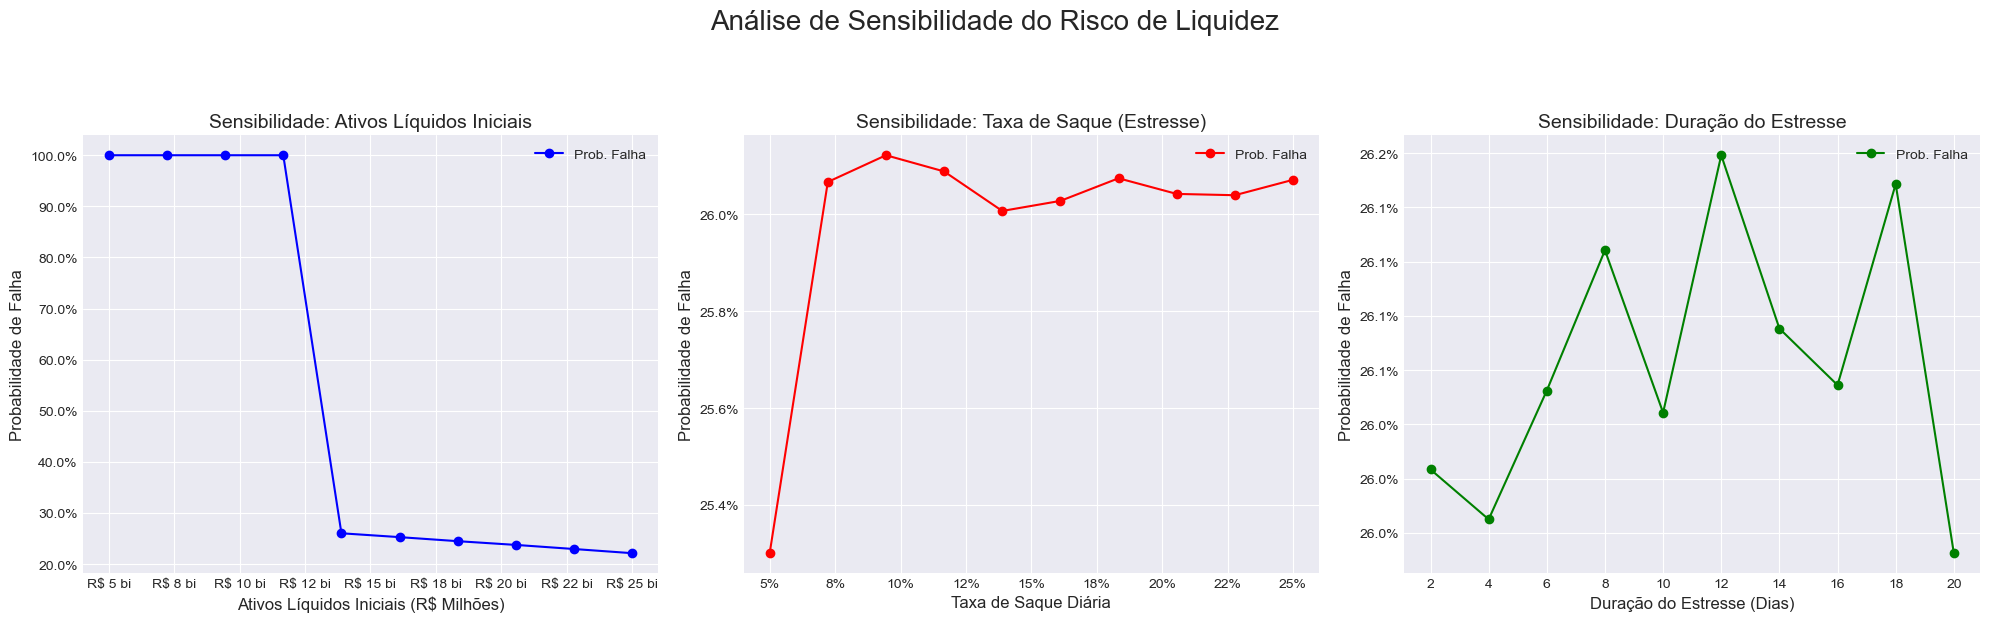

In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

# Este script Python simula o Risco de Liquidez de Financiamento (Liquidity Funding Risk).
# O cenário simula uma "corrida aos depósitos" (bank run) desencadeada por um
# evento de risco operacional (crise de confiança).

# --- 1. Parâmetros de Simulação Base ---

# Configurações do Banco (Valores ilustrativos em milhões de R$)
PARAMS_BASE = {
    "LIQUID_ASSETS_INICIAL": 15000.0,  # Ativos líquidos (Caixa, Títulos Públicos)
    "SHORT_TERM_FUNDING": 50000.0,     # Financiamento de curto prazo (Depósitos, CDBs < 30 dias)
    
    # Parâmetros de Estresse (Ref. Hull, Cap. 22)
    "PROB_EVENTO_ESTRESSE_DIA": 0.01,  # 1% de chance de um evento de crise de confiança por dia
    "TAXA_SAQUE_NORMAL": 0.01,         # 1% dos depósitos sacados por dia (normal)
    
    # --- PARÂMETRO AJUSTADO ---
    # Reduzido de 0.15 para 0.08.
    # O valor anterior (15%) causava falha no Dia 3, tornando a "duração" irrelevante.
    # O valor de 8% causa falha por volta do Dia 5-6, tornando a duração um
    # parâmetro sensível e significativo para a análise.
    "TAXA_SAQUE_ESTRESSE": 0.08,       # 8% dos depósitos sacados por dia (corrida ao banco)
    "DIAS_ESTRESSE_DURACAO": 10,       # Quantos dias a crise de confiança dura
    
    # Configurações da Simulação
    "PERIODO_SIMULACAO_DIAS": 30       # Testar sobrevivência em 30 dias
}

# Configurações de Monte Carlo
NUM_SIMULACOES = 100000

# --- 2. Função de Simulação (Simulação Individual) ---

def executar_simulacao_liquidez(params):
    """
    Executa uma única simulação de 30 dias do balanço de liquidez do banco.
    Recebe um dicionário de parâmetros.
    Retorna True se o banco falhar (iliquidez), False se sobreviver.
    """

    # Desempacota os parâmetros para a simulação
    ativos_liquidos = params["LIQUID_ASSETS_INICIAL"]
    financiamento_curto_prazo = params["SHORT_TERM_FUNDING"]
    prob_evento = params["PROB_EVENTO_ESTRESSE_DIA"]
    taxa_saque_normal = params["TAXA_SAQUE_NORMAL"]
    taxa_saque_estresse = params["TAXA_SAQUE_ESTRESSE"]
    duracao_estresse = params["DIAS_ESTRESSE_DURACAO"]
    periodo_simulacao = params["PERIODO_SIMULACAO_DIAS"]

    em_estresse = False
    dias_estresse_restantes = 0

    for dia in range(periodo_simulacao):

        # Verifica se um novo evento de estresse começa (Risco Operacional/Confiança)
        if not em_estresse and random.random() < prob_evento:
            em_estresse = True
            dias_estresse_restantes = duracao_estresse

        # Determina a taxa de saque
        if em_estresse:
            taxa_saque_diaria = taxa_saque_estresse
            dias_estresse_restantes -= 1
            if dias_estresse_restantes <= 0:
                em_estresse = False
        else:
            taxa_saque_diaria = taxa_saque_normal

        # Calcula o volume de saques
        saques_no_dia = financiamento_curto_prazo * taxa_saque_diaria

        # Atualiza o balanço
        financiamento_curto_prazo -= saques_no_dia
        ativos_liquidos -= saques_no_dia

        # Verifica a falha de liquidez
        if ativos_liquidos < 0:
            return True  # Falha de Liquidez

    return False # Sobreviveu aos 30 dias

# --- 3. Função de Execução (Monte Carlo) ---

def run_monte_carlo(params, num_simulacoes):
    """
    Executa o loop de Monte Carlo (N simulações) para um dado conjunto de parâmetros.
    Retorna a probabilidade de falha.
    """
    falhas_de_liquidez = 0
    for i in range(num_simulacoes):
        if executar_simulacao_liquidez(params):
            falhas_de_liquidez += 1
            
    return falhas_de_liquidez / num_simulacoes

# --- 4. Análise de Sensibilidade e Gráficos ---

def run_sensitivity_analysis(params_base, num_simulacoes):
    """
    Executa a análise de sensibilidade variando os parâmetros-chave
    e plota os resultados.
    """
    print("\n--- Iniciando Análise de Sensibilidade ---")
    
    # --- 4.1. Sensibilidade: Ativos Líquidos Iniciais ---
    print("Analisando sensibilidade: LIQUID_ASSETS_INICIAL...")
    resultados_ativos = []
    # Varia de 5.000 a 25.000
    range_ativos = np.linspace(5000.0, 25000.0, 10) 
    
    for valor_ativo in range_ativos:
        params_teste = params_base.copy()
        params_teste["LIQUID_ASSETS_INICIAL"] = valor_ativo
        prob_falha = run_monte_carlo(params_teste, num_simulacoes)
        resultados_ativos.append(prob_falha)

    # --- 4.2. Sensibilidade: Taxa de Saque Estresse ---
    print("Analisando sensibilidade: TAXA_SAQUE_ESTRESSE...")
    resultados_taxa = []
    # Varia de 5% a 25% (este range continua bom)
    range_taxa = np.linspace(0.05, 0.25, 10)
    
    for valor_taxa in range_taxa:
        params_teste = params_base.copy()
        params_teste["TAXA_SAQUE_ESTRESSE"] = valor_taxa
        prob_falha = run_monte_carlo(params_teste, num_simulacoes)
        resultados_taxa.append(prob_falha)

    # --- 4.3. Sensibilidade: Duração do Estresse ---
    print("Analisando sensibilidade: DIAS_ESTRESSE_DURACAO...")
    resultados_duracao = []
    # Varia de 2 dias a 20 dias (este range agora mostrará o "ponto de virada")
    range_duracao = np.linspace(2, 20, 10, dtype=int) 
    
    for valor_duracao in range_duracao:
        params_teste = params_base.copy()
        params_teste["DIAS_ESTRESSE_DURACAO"] = int(valor_duracao)
        prob_falha = run_monte_carlo(params_teste, num_simulacoes)
        resultados_duracao.append(prob_falha)

    print("--- Geração de Gráficos ---")
    
    # --- 4.4. Plotagem ---
    plt.style.use('seaborn-v0_8-darkgrid')
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))
    
    fig.suptitle('Análise de Sensibilidade do Risco de Liquidez', fontsize=20, y=1.03)

    # Plot 1: Ativos Líquidos
    ax1.plot(range_ativos, resultados_ativos, 'b-o', label='Prob. Falha')
    ax1.set_title('Sensibilidade: Ativos Líquidos Iniciais', fontsize=14)
    ax1.set_xlabel('Ativos Líquidos Iniciais (R$ Milhões)', fontsize=12)
    ax1.set_ylabel('Probabilidade de Falha', fontsize=12)
    ax1.yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1.0, decimals=1))
    ax1.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, p: f'R$ {x/1000:.0f} bi'))
    ax1.legend()

    # Plot 2: Taxa de Saque
    ax2.plot(range_taxa, resultados_taxa, 'r-o', label='Prob. Falha')
    ax2.set_title('Sensibilidade: Taxa de Saque (Estresse)', fontsize=14)
    ax2.set_xlabel('Taxa de Saque Diária', fontsize=12)
    ax2.set_ylabel('Probabilidade de Falha', fontsize=12)
    ax2.xaxis.set_major_formatter(mticker.PercentFormatter(xmax=1.0, decimals=0))
    ax2.yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1.0, decimals=1))
    ax2.legend()

    # Plot 3: Duração do Estresse
    ax3.plot(range_duracao, resultados_duracao, 'g-o', label='Prob. Falha')
    ax3.set_title('Sensibilidade: Duração do Estresse', fontsize=14)
    ax3.set_xlabel('Duração do Estresse (Dias)', fontsize=12)
    ax3.set_ylabel('Probabilidade de Falha', fontsize=12)
    # Adicionando um ticker de inteiros para o eixo X
    ax3.xaxis.set_major_locator(mticker.MaxNLocator(integer=True)) 
    ax3.yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1.0, decimals=1))
    ax3.legend()

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# --- 5. Execução Principal ---

def main():
    print("Iniciando Teste de Estresse de Risco de Liquidez (Simulação de Monte Carlo)")
    print("-" * 60)
    print(f"Simulações (Cenário Base): {NUM_SIMULACOES:,.0f}")
    print(f"Período de teste: {PARAMS_BASE['PERIODO_SIMULACAO_DIAS']} dias")
    print(f"Ativos Líquidos Iniciais: R$ {PARAMS_BASE['LIQUID_ASSETS_INICIAL']:,.0f} milhões")
    print(f"Financiamento de Curto Prazo: R$ {PARAMS_BASE['SHORT_TERM_FUNDING']:,.0f} milhões")
    print(f"Taxa de Saque (Estresse): {PARAMS_BASE['TAXA_SAQUE_ESTRESSE'] * 100:.1f}% ao dia")
    print(f"Duração do Estresse: {PARAMS_BASE['DIAS_ESTRESSE_DURACAO']} dias")
    print("-" * 60)

    # Executa a simulação base
    probabilidade_falha_base = run_monte_carlo(PARAMS_BASE, NUM_SIMULACOES)

    # Resultados Base
    print("\n--- Resultados do Teste de Estresse (Cenário Base) ---")
    print(f"Probabilidade de Falha de Liquidez em {PARAMS_BASE['PERIODO_SIMULACAO_DIAS']} dias: {probabilidade_falha_base * 100:.4f}%")

    if probabilidade_falha_base > 0.01:
        print("\nRECOMENDAÇÃO (Base): ALTA PROBABILIDADE DE FALHA. Revisar o colchão de liquidez (HQLA).")
    else:
        print("\nRECOMENDAÇÃO (Base): Baixa probabilidade de falha sob este cenário.")
    
    # Executa a análise de sensibilidade e gera gráficos
    run_sensitivity_analysis(PARAMS_BASE, NUM_SIMULACOES)

if __name__ == "__main__":
    main()

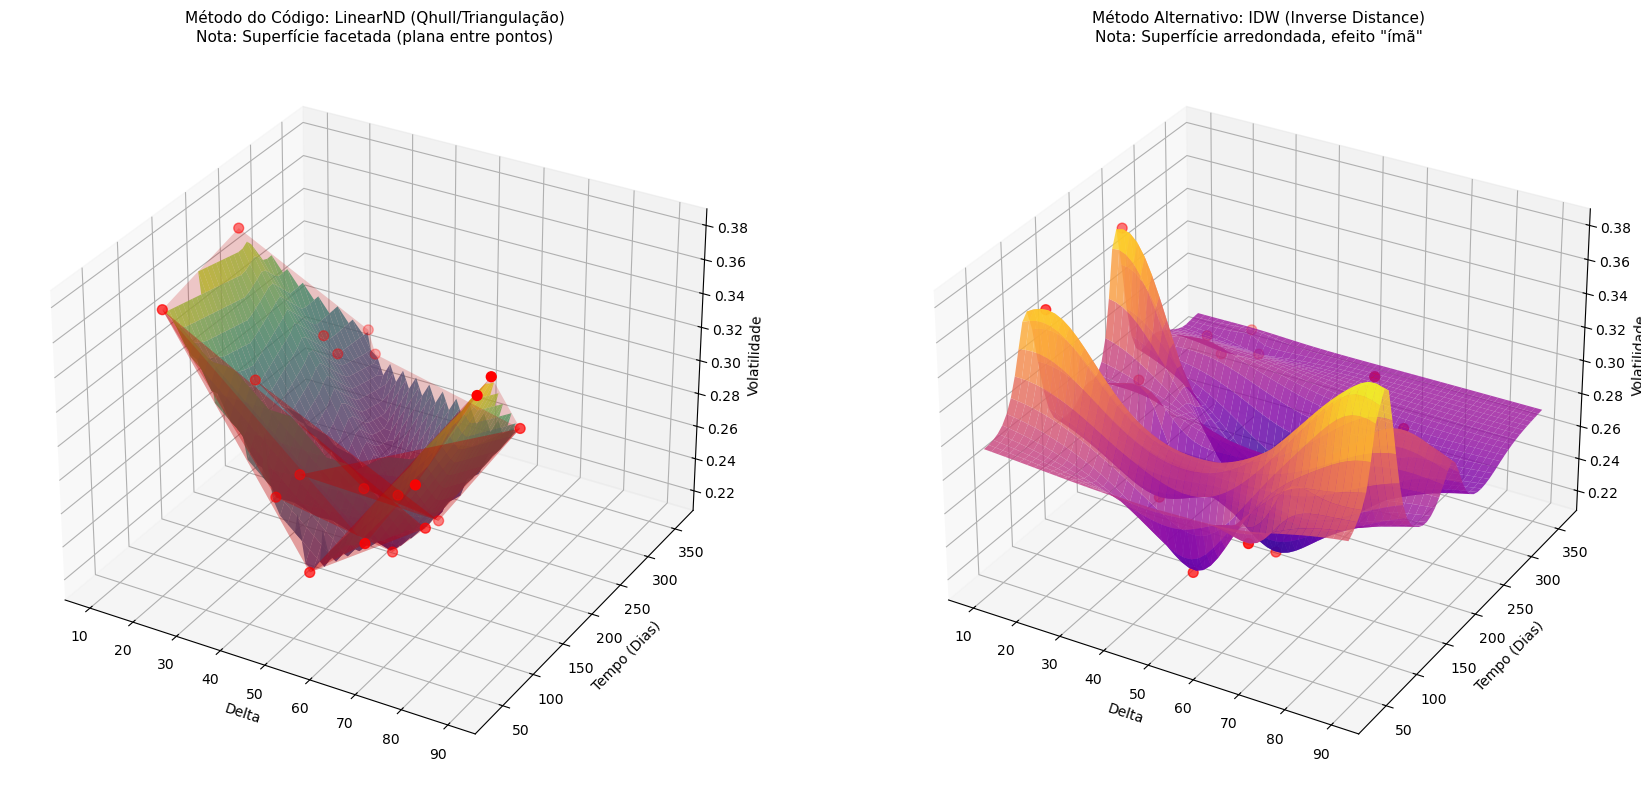

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import LinearNDInterpolator
from mpl_toolkits.mplot3d import Axes3D

def simple_idw(x, y, z, xi, yi, power=2):
    """Implementação simples de IDW para comparação"""
    dist = np.sqrt((x[:, None] - xi.flatten())**2 + (y[:, None] - yi.flatten())**2)
    weights = 1.0 / (dist**power + 1e-12)
    weights /= weights.sum(axis=0)
    zi = np.dot(weights.T, z)
    return zi.reshape(xi.shape)

# 1. Criar dados sintéticos de Volatilidade (Smile/Skew)
# Pontos aleatórios simulando (Delta, Tempo)
np.random.seed(42)
n_points = 20
delta = np.random.uniform(10, 90, n_points)  # Delta 10 a 90
tempo = np.random.uniform(30, 360, n_points) # Prazo 30 a 360 dias

# Função geradora de Vol (Sintética)
# Vol mais alta em Deltas baixos (Put OTM) e prazos curtos
vol = 0.20 + (0.5 - delta/100)**2 + 5/(tempo+50) 

# 2. Criar Grid para Interpolação
grid_delta, grid_tempo = np.meshgrid(
    np.linspace(10, 90, 50),
    np.linspace(30, 360, 50)
)

# 3. Método 1: Qhull (LinearNDInterpolator) - O que seu código usa
# Triangulação de Delaunay
interp_qhull = LinearNDInterpolator(list(zip(delta, tempo)), vol)
Z_qhull = interp_qhull(grid_delta, grid_tempo)

# 4. Método 2: IDW (Inverse Distance Weighting)
Z_idw = simple_idw(delta, tempo, vol, grid_delta, grid_tempo, power=2)

# --- Plotagem ---
fig = plt.figure(figsize=(18, 8))

# Plot Qhull
ax1 = fig.add_subplot(121, projection='3d')
ax1.plot_trisurf(delta, tempo, vol, color='red', alpha=0.2) # Mostra os triângulos
surf1 = ax1.plot_surface(grid_delta, grid_tempo, Z_qhull, cmap='viridis', edgecolor='none', alpha=0.8)
ax1.scatter(delta, tempo, vol, c='r', marker='o', s=50, label='Dados Reais')
ax1.set_title('Método do Código: LinearND (Qhull/Triangulação)\nNota: Superfície facetada (plana entre pontos)', fontsize=11)
ax1.set_xlabel('Delta')
ax1.set_ylabel('Tempo (Dias)')
ax1.set_zlabel('Volatilidade')

# Plot IDW
ax2 = fig.add_subplot(122, projection='3d')
surf2 = ax2.plot_surface(grid_delta, grid_tempo, Z_idw, cmap='plasma', edgecolor='none', alpha=0.8)
ax2.scatter(delta, tempo, vol, c='r', marker='o', s=50, label='Dados Reais')
ax2.set_title('Método Alternativo: IDW (Inverse Distance)\nNota: Superfície arredondada, efeito "ímã"', fontsize=11)
ax2.set_xlabel('Delta')
ax2.set_ylabel('Tempo (Dias)')
ax2.set_zlabel('Volatilidade')

plt.tight_layout()
plt.show()